<a href="https://colab.research.google.com/github/ssv273/Neural_Univesity/blob/main/hw_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 19 14:37:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.4-py3-none-any.whl size=18688 sha256=da05ab0b5c31bf9a7017b76446032d737235f91067baf72969a5e8b76a7ca527
  Stored in directory: /root/.cache/pip/wheels/71/de/ad/759faf4fea1e9b0fd935da28847aa3ca2eef14a888c2dc4952
Successfully built pandarallel


In [3]:
import pandas as pd
from xml.dom import minidom
import re
import os
import time
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #модуль для разбивки данных на обучающую и тестовую выборки
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta, Adam # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели


In [4]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [5]:
def process_tuv(tuv):
    lang = tuv.getAttribute("lang")
    if lang == '':
        lang = tuv.getAttribute("xml:lang")
    seg = tuv.getElementsByTagName('seg')[0]
    txt = seg.childNodes[0].data
    return lang, txt

def read(path):

    """Read function takes in a path to TMX translation file and outputs the metadata and a pandas dataframe.
    Args:
        param1 (str): The path to the TMX translation file
    Returns:
        dict: The header of the TMX file, which contains metadata
        DataFrame: A Pandas Dataframe. Each line item consists of source_language, source_sentence, target_language, target_sentence
    """
    # parse an xml file by name
    tmx = minidom.parse(path)

    # Get metadata
    metadata = {}
    header = tmx.getElementsByTagName('header')[0]
    for key in header.attributes.keys():
        metadata[key] = header.attributes[key].value
        
    srclang = metadata['srclang']

    # Get translation sentences
    body = tmx.getElementsByTagName('body')[0]
    translation_units = body.getElementsByTagName('tu')
    items = []
    count_unpaired = 0
    for tu in translation_units:
        if len(tu.getElementsByTagName('tuv')) < 2:
            print("Unpaired translation. Ignoring...")
            count_unpaired = count_unpaired + 1
        else:
            srclang, srcsentence = process_tuv(tu.getElementsByTagName('tuv')[0])
            targetlang, targetsentence = process_tuv(tu.getElementsByTagName('tuv')[1])
            item = {
                'source_language': srclang,
                'source_sentence': srcsentence,
                'target_language': targetlang,
                'target_sentence': targetsentence
            }
            items.append(item)

    df = pd.DataFrame(items)
    if count_unpaired > 0:
       print("The data contained %d unpaired translations which were ignored" % (count_unpaired))
    return metadata, df

In [6]:
metadata, df = read("/content/drive/MyDrive/Neural_Univesity/hw_24/en-ru.tmx")

In [7]:
metadata

{'adminlang': 'en',
 'creationdate': 'Wed Jul 10 23:20:43 2019',
 'creationtool': 'Uplug',
 'creationtoolversion': 'unknown',
 'datatype': 'PlainText',
 'o-tmf': 'unknown',
 'segtype': 'sentence',
 'srclang': 'en'}

In [8]:
df.head(1)

,source_language,source_sentence,target_language,target_sentence
0,en,For once in my life I'm doing a good deed... A...,ru,Один раз в жизни я делаю хорошее дело... И оно...


In [9]:
df = df[:70000]

In [10]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
#     w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [11]:
df['preprocess_source_sentence'] = df['source_sentence'].parallel_apply(preprocess_sentence)
df['preprocess_target_sentence'] = df['target_sentence'].parallel_apply(preprocess_sentence)

In [12]:
df.head(2)

,source_language,source_sentence,target_language,target_sentence,preprocess_source_sentence,preprocess_target_sentence
0,en,For once in my life I'm doing a good deed... A...,ru,Один раз в жизни я делаю хорошее дело... И оно...,<start> For once in my life I'm doing a good d...,<start> Один раз в жизни я делаю хорошее дело ...
1,en,Let's try something.,ru,Давайте что-нибудь попробуем!,<start> Let's try something . <end>,<start> Давайте что-нибудь попробуем ! <end>


In [13]:
input_texts = df['preprocess_source_sentence'].to_list()
target_texts = df['preprocess_target_sentence'].to_list()

In [14]:
len(input_texts), len(target_texts)

(70000, 70000)

In [15]:
input_texts[10], target_texts[10]

('<start> I will be back soon . <end>', '<start> Скоро вернусь . <end>')

In [16]:
def tokenize(lang):
    lang_tokenizer = Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [17]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [18]:
input_tensor.shape

(70000, 49)

In [19]:
len(inp_lang_tokenizer.word_index)

12329

In [20]:
# Для удобства создадим мини-функцию, возвращающую максимальную длину тензора
def max_length(tensor): #функция принимает на вход тензор(фразы в виде последовательности индексов)
  return max(len(t) for t in tensor) #и возвращает значение максимальной длины его элемента 

In [21]:
# Вычислим максимальные длины тензоров для английского и русского языков, используя ранее заданную функцию
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
max_length_targ, max_length_inp

(48, 49)

In [22]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [23]:
def convert(language_tokenizer, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, language_tokenizer.index_word[t]))
print ("Фраза на английском языке; соответствие индекса и слова")
convert(inp_lang_tokenizer, input_tensor_train[0])
print ()
print ("Фраза на русском языке; соответствие индекса и слова")
convert(targ_lang_tokenizer, target_tensor_train[0])
print ()

Фраза на английском языке; соответствие индекса и слова
1 ----> <start>
200 ----> keep
4 ----> the
185 ----> children
192 ----> away
47 ----> from
4 ----> the
4939 ----> knives
3 ----> .
2 ----> <end>

Фраза на русском языке; соответствие индекса и слова
1 ----> <start>
2443 ----> держите
14004 ----> ножи
6 ----> в
26634 ----> недоступном
47 ----> для
292 ----> детей
336 ----> месте
3 ----> .
2 ----> <end>



# Параметры нейросети

In [24]:
######################
# Создаем tf.data датасет (Раздел tf.data.Dataset API предлагает построить готовый конвейер для обучения моделей)
######################
# Метод .shuffle с параметром BUFFER_SIZE задаст случайность подачи тренировочных сэмплов в процессе обучения(против переобучения) 
BUFFER_SIZE = len(input_tensor_train) #укажем что случайно сэмплировать будем по всей длине обучающейся выборки

BATCH_SIZE = 16 #указываем размер батча
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE # укажем количество шагов в одной эпохе
embedding_dim = 256 #размерность эмбеддинга, векторного пространства
units = 1024 #задаем размер слоя(количество нейронов в слое) 
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1 #задаем размер немецкого словаря
#vocab_tar_size = len(inp_lang_tokenizer.word_index)+1 #задаем размер английского словаря
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1 #задаем размер английского словаря

# Создаём датасет из массивов Numpy(рус и анг тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
%time dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Посмотрим на форму примеров полученных батчей
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
print(vocab_inp_size, vocab_tar_size)

CPU times: user 430 ms, sys: 463 ms, total: 892 ms
Wall time: 3.26 s
12330 33892


# Создаём классы Encoder, Attention, Decoder

In [25]:
######################
# Создаем класс для кодировщика Encoder
######################
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz): #указываем атрибуты класса
    super(Encoder, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz #атрибут возвращает размер батча
    self.enc_units = enc_units #атрибут возвращает размер слоя в кодировщике
    self.embedding = Embedding(vocab_size, embedding_dim) #атрибут эмбеддинга - слой Кераса с размером словаря на входе и с dim=256
    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки
    self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  # Метод принимает входную фразу и начальное состояние
  def call(self, x, hidden): #при обращении к экземпляру класса как к функции, будет вызываться этот метод:
    x = self.embedding(x) # входящие тензоры преобразовываются в эмбеддинг
    output, state = self.gru(x, initial_state = hidden) #затем пропускаются через GRU и получаем выход + новое состояние
    return output, state #вызов метода/функции вернёт выход из сети GRU и состояние на выходе

  def initialize_hidden_state(self): #создаем метод инициализации состояний на скрытых слоях
    return tf.zeros((self.batch_sz, self.enc_units)) #задаем начальное состояние как размер батча на размер слоя
    
#  input tensor(фраза в виде индексов)---->Encoder----> output(значение на выходе) и hidden_state(состояние на выходе)

In [26]:
# Создадим модель кодировщика по уже заданным параметрам 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Подадим в качестве примера какой-то сэмпл(Тензор[64, 12]) на вход Encoder'у и визуализируем, что получим

sample_hidden = encoder.initialize_hidden_state() #инициализируем начальное скрытое состояние
# Даем Encoder'у сэмпл и начальное состояние, и получим выход из сети GRU и состояние на выходе (вызывается метод call класса Encoder)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (16, 49, 1024)
Размеры скрытого состояния: (batch size, units) (16, 1024)


In [27]:
print(sample_hidden.shape)
print(sample_output.shape)

(16, 1024)
(16, 49, 1024)


In [28]:
######################
# Создаем класс Attention для внедрения механизма внимания
######################
class BahdanauAttention(Model): #название класса именем создателя механизма Дмитрия Богданова(Bahdanau)
  def __init__(self, units): # создаем слой внимания из указанного кол-ва нейронов
    super(BahdanauAttention, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке
    self.W1 = Dense(units) #атрибут: получаем веса, пропуская через полносвязный слой
    self.W2 = Dense(units) #атрибут: получаем веса, пропуская через полносвязный слой
    self.V =  Dense(1) #атрибут: пропускаем через Dense с одним нейроном, получаем отдельный вес на каждый такт

  def call(self, hidden_state, values): 
    # Форма состояния на скрытом слое (batch_size, hidden size)
    # Форму состояния на каждом такте увеличим до (batch_size, 1, hidden size)
    # Добавляем это для того, чтобы получить оценку
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

    # Форма оценки score (размер батча, макс.длина слов на входе, 1), однёрка в конце, чтобы применить self.V
    # До применения self.V оценка была бы (размер батча, макс.длина слов на входе, количество нейронов в слое)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # К полученной оценке применим Софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score - (размер батча, макс.длина слов на входе, 1); Софтмакс применяем к оси "макс.длина слов"
    attention_weights = tf.nn.softmax(score, axis=1)

    # Построим вектор контекста 
    context_vector = attention_weights * values # веса внимания перемножим со значениями(выхода из кодировщика)
    # Сумму также применяем по оси "макс.длина слов на входе"
    context_vector = tf.reduce_sum(context_vector, axis=1) #размеры вектора контекста после суммирования будут (размер батча, размер слоя)

    return context_vector, attention_weights #возвращает вектор контекста и веса внимания

# encoder hidden state и  output ---->Attention Layer----> context vector(вектор контекста) и attention weights (веса внимания)

In [29]:
# Проверим, как работает слой
attention_layer = BahdanauAttention(10)
# Подадим на вход слою внимания выход из Encodera и его состояние, и получим значение и веса внимания
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

Размеры значения внимания: (размер батча, размер слоя) (16, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (16, 49, 1)


In [30]:
######################
# Создаем класс для декодировщика Decoder
######################
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz #атрибут возвращает размер батча
    self.dec_units = dec_units #атрибут возвращает размер слоя в декодере(кол-во нейронов)
    self.embedding = Embedding(vocab_size, embedding_dim) #атрибут эмбеддинга - слой Кераса с размером словаря на входе и (dim=256) на выходе

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки    
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size) #атрибут вызовет полносвязный слой с размером словаря

    self.attention = BahdanauAttention(self.dec_units) #атрибут подключит механизм внимания, описанный ранее

  def call(self, x, hidden, enc_output):
    # enc_output размеры (batch_size, max_length, hidden_size - размер батча, макс.длина фраз, разм.скр.слоя)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # входящий тензор слова пропускаем через эмбеддинг (получаем размеры batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # дальше конкатенируем с вектором контекста (получаем размеры batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x)

    # output размеры (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # пропускаем через полносвязный слой
    x = self.fc(output) #output размеры (batch_size, vocab)

    return x, state, attention_weights

In [31]:
# Проверим работу декодера, подав на вход случайный массив с нужной размерностью
# Создали декодер с параметрами(размер анг.словаря, размерность эмбеддинга, кол-во нейронов, размер батча)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# Подаём на вход случайный массив с нужной размерностью, состояние и выход с кодировщика
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (16, 33892)


In [32]:
######################
# Определяем функцию потерь
######################
optimizer = Adam() # из оптимизаторов кераса выбираем Adam
# Используем SparseCategoricalCrossentropy, к-я может работать не с категориальными лейблами
loss_object = tf.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #логит - тензор к к-му применим софтмакс

def loss_function(real, pred): # Запишем функцию потерь, на вход подаем фактический и предсказанный результат
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #накидываем "маску" которая оставит для работы ненулевые значения
  loss_ = loss_object(real, pred) #фактические и предсказанные результаты передаем в SparseCategoricalCrossentropy и получаем ошибку

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  #reduce_mean - среднее любого выбранного тензора
  return tf.reduce_mean(loss_)

# Обучение Нейросети

In [33]:
# Сохраняем процесс обучения модели чекпоинтами тензорфлоу
checkpoint_dir = './training_checkpoints' #даем ссылку на директорию
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #добавляем префикс "ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) #сохраняем состояния/показатели оптимизатора и моделей

In [34]:
######################
# Создадим функцию запуска обучения модели 
######################
@tf.function
def train_step(inp, targ, enc_hidden): #функция принимает тензоры(фразы в виде индексов) и состояние в кодировщике
  loss = 0 #создаем переменную, в которую будем записывать ошибку

  # Все операции по вычислению градиента записываются на ленту(tape) и мы получаем к ним доступ
  with tf.GradientTape() as tape:
    # Передаем тензор и начальное состояние в кодировщик и получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden #передадим это состояние декодеру

    # Передаем в качестве входа в декодер индекс токена "<start>"
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Техника "Teacher forcing" - подаем предыдущее выходное слово на вход следущего в декодере. Targ.shape[64, 9]
    for t in range(1, targ.shape[1]): #для каждого слова из английской фразы
      # Передаем в обработку декодеру начальный токен, состояние на выходе из кодера, и выход из кодера
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # Получаем от декодера предсказание и обновленное состояние
      # Обновляем ошибку для текущих предсказаний
      loss += loss_function(targ[:, t], predictions)

      # Используем "Teacher forcing"
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1])) # Получаем ошибку на батче . Targ.shape[64, 9]. Делим на 9

  variables = encoder.trainable_variables + decoder.trainable_variables # создаем переменные, для которых TensorFlow будет вычислять градиенты

  gradients = tape.gradient(loss, variables) #отслеживаем градиент
  
  optimizer.apply_gradients(zip(gradients, variables)) #оптимизируем веса

  return batch_loss #функция обучения вернет ошибку на батче

In [35]:
######################
# Запуск обучения
######################
EPOCHS = 30 #устанавливаем количество эпох

In [36]:
for epoch in range(EPOCHS): #на каждой эпохе
  start = time.time() #включаем счетчик времени

  enc_hidden = encoder.initialize_hidden_state() #задаем начальное состояние на скрытом слое encodera
  total_loss = 0 #начальное значение итоговой ошибки

  # Для батча, входного и выходного тензора на каждом шаге эпохи
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden) #передадим в функцию тензоры и состояние в кодировщике, обучим и получим ошибку на батче
    total_loss += batch_loss #добавим ее в итоговую ошибку

  # Каждые 10 эпох будем сохранять чекпоинты
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  # Выведем показатели после каждой эпохи
  print('Эпоха {}/{} Ошибка {:.4f}'.format(epoch + 1, EPOCHS, total_loss / steps_per_epoch))
  print('Время на 1 эпоху {} сек\n'.format(round(time.time() - start), 1))

Эпоха 1/30 Ошибка 0.8337
Время на 1 эпоху 1025 сек

Эпоха 2/30 Ошибка 0.5414
Время на 1 эпоху 957 сек

Эпоха 3/30 Ошибка 0.3588
Время на 1 эпоху 956 сек

Эпоха 4/30 Ошибка 0.2346
Время на 1 эпоху 956 сек

Эпоха 5/30 Ошибка 0.1606
Время на 1 эпоху 956 сек

Эпоха 6/30 Ошибка 0.1233
Время на 1 эпоху 956 сек

Эпоха 7/30 Ошибка 0.1019
Время на 1 эпоху 955 сек

Эпоха 8/30 Ошибка 0.0868
Время на 1 эпоху 956 сек

Эпоха 9/30 Ошибка 0.0758
Время на 1 эпоху 956 сек

Эпоха 10/30 Ошибка 0.0688
Время на 1 эпоху 959 сек

Эпоха 11/30 Ошибка 0.0634
Время на 1 эпоху 956 сек

Эпоха 12/30 Ошибка 0.0590
Время на 1 эпоху 957 сек

Эпоха 13/30 Ошибка 0.0561
Время на 1 эпоху 956 сек

Эпоха 14/30 Ошибка 0.0533
Время на 1 эпоху 956 сек

Эпоха 15/30 Ошибка 0.0513
Время на 1 эпоху 955 сек

Эпоха 16/30 Ошибка 0.0497
Время на 1 эпоху 955 сек

Эпоха 17/30 Ошибка 0.0478
Время на 1 эпоху 947 сек

Эпоха 18/30 Ошибка 0.0462
Время на 1 эпоху 948 сек

Эпоха 19/30 Ошибка 0.0449
Время на 1 эпоху 948 сек

Эпоха 20/30 Ошибка 0

In [37]:
######################
# Функция запуска и оценки модели переводчика
######################
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp)) # создаем начальные настройки графика внимания

    sentence = preprocess_sentence(sentence) #предобрабатываем предложение

    #inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')] #преобразовываем в послед-ть индексов
    inputs = []
    for i in sentence.split(' '):
      try:
        ind_inp = inp_lang_tokenizer.word_index[i]
        inputs.append(ind_inp)
      except:
        #ind_inp = " "
        print( f"В словаре нет слова '{i}'")
      

    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post') # делаем паддинг
    inputs = tf.convert_to_tensor(inputs) #конвертируем в тф тензор

    result = '' #сюда запишем результат

    hidden = [tf.zeros((1, units))] #задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden) #передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden #состояние кодера передаем в декодер
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0) #передаем на вход декодеру <start> в виде индекса

    for t in range(max_length_targ): #идем по макс.длине фраз выходного языка(анг)
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Сохраняем веса внимания для графика
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        # Аргмаксом вытаскиваем предсказанное слово
        predicted_id = tf.argmax(predictions[0]).numpy()
        # Результат конвертируем из индекса в слово и ложим в result = ''
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '
        # Если предсказанное слово - <end>, то останавливаемся, возвращаем результаты, выводим на графике
        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # предсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [38]:
# Создаем функцию для построение плота с весами внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [39]:
def translate(sentence): # функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)

    print('Входящая фраза: %s' % (sentence))
    print('Предсказанный перевод: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

В словаре нет слова 'How'
Входящая фраза: <start> How are you ? <end>
Предсказанный перевод: ты ? <end> 


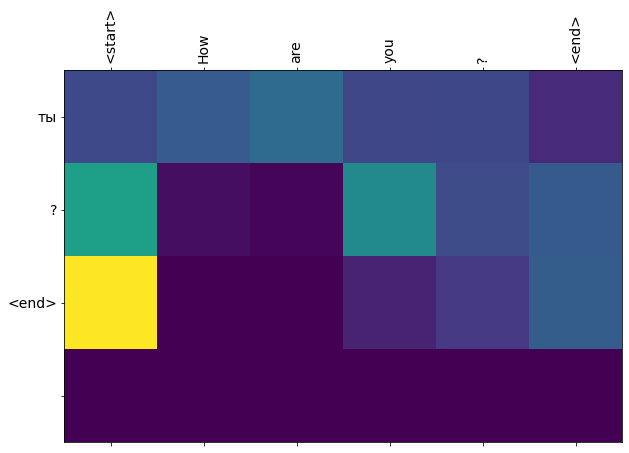

In [40]:
translate('How are you ?')

В словаре нет слова 'There'
Входящая фраза: <start> There is a cat on the table <end>
Предсказанный перевод: это кот на столе . <end> 


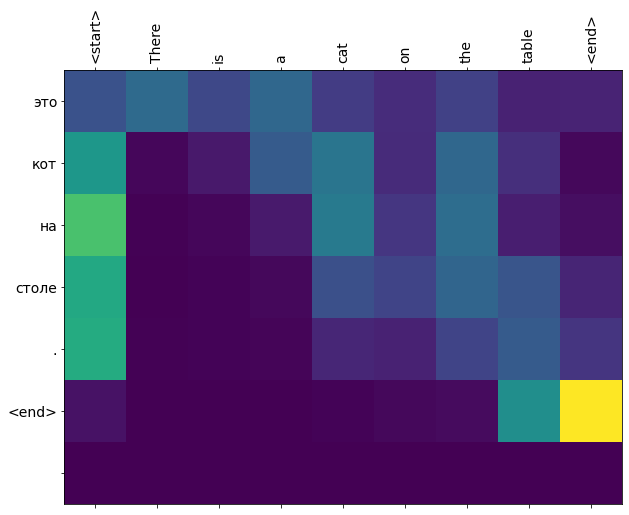

In [41]:
translate('There is a cat on the table')

В словаре нет слова 'Where'
Входящая фраза: <start> Where are you from ? <end>
Предсказанный перевод: вы из америки ? <end> 


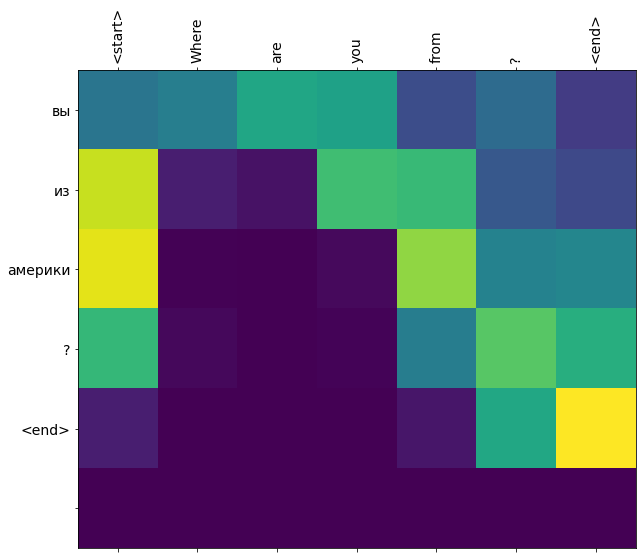

In [42]:
translate("Where are you from ?")

В словаре нет слова 'For'
В словаре нет слова 'I'm'
Входящая фраза: <start> For once in my life I'm doing a good deed . . . <end>
Предсказанный перевод: раз в жизни говорит на хорошем состоянии . <end> 


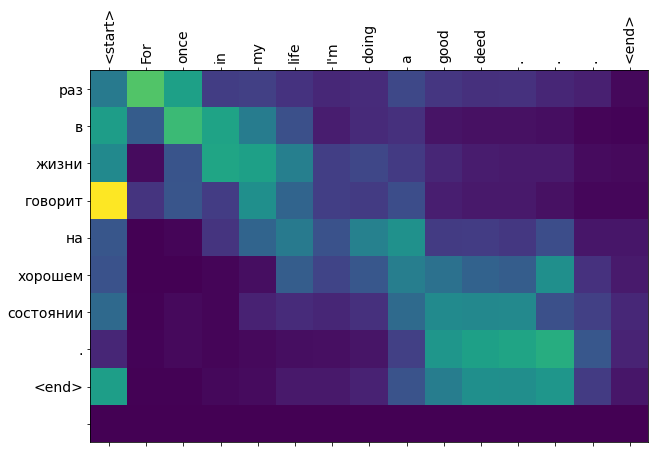

In [43]:
translate("For once in my life I'm doing a good deed... ")